# SLT-CE-5: Pairwise Clustering

Grade: 6.0

<p style="background-color:#adebad;"> 
<b>NOTE</b>: We would like to remind you, that we strongly recommend use environment from environment.yml in this coding exercise repo. Otherwise, we reserve the right to deduct points for non-working code if you worked in a different environment incompatible with the provided one.
</p>

In this coding exercise you will apply pairwise clustering for proximity data and you will see how to use the mean-field approximation (MFA) approach with the EM-algorithm to get a labeling for a data object encoded by similarity and dissimilarity matrices. You will also be able to implement modifications of the EM-scheme to obtain embeddings into an Euclidean space.

<b> References: </b>

[1] T. Hoffman, JM Buhmann. Pairwise Data Clustering by Deterministic Annealing, 1996: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.8.9812&rep=rep1&type=pdf 

Optionally, the following resources could be helpful:

[2] Lecture 7. Pairwise clustering: https://ml2.inf.ethz.ch/courses/slt/lectures/slt21_lecture07.pdf

[3] Lecture script (previous version). Chapter 3.2: https://ml2.inf.ethz.ch/courses/slt/tutorials/SLT_Script.pdf

[4] Lecture 4. Determenistic Annealing: https://ml2.inf.ethz.ch/courses/slt/lectures/slt21_lecture04.pdf

[5] Lecture 8. Mean-field approximation: https://ml2.inf.ethz.ch/courses/slt/lectures/slt21_lecture08.pdf

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import sys
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.validation import check_is_fitted
from sklearn.cluster import SpectralClustering
from scipy.io import loadmat

#Please use in all section except 5.5 where you have to use random seeds
np.random.seed(111)

<h2 style="background-color:#f0b375;"> Data </h2>

## ProDom Data

ProDom is a comprehensive set of protein domain families [6]. A ProDom subset of 2604 protein domain sequences from the ProDom set was selected by [7]. These are chosen based on a high similarity to at least one sequence contained in the first four folds of the SCOP database. The pairwise structural alignments are computed [7]. Each SCOP sequence belongs to a group, as labeled by the experts [8]. The same four classes are assigned here.

<b> References: </b>

[6] F. Corpet, F. Servant, J. Gouzy and D. Kahn, ProDom and ProDom-CG: tools for protein domain analysis and whole genome comparisons, Nucleid Acids Res., vol. 28, 267-269, 2000.

[7] V. Roth, J. Laub, J.M. Buhmann, and K.-R. Mueller, Going metric: Denoising pairwise data, Advances in Neural Information Processing Systems, 841-856, MIT Press, 2003.

[8] A.G. Murzin, S.E. Brenner, T. Hubbard and C. Chothia, SCOP: a structural classification of proteins database for the investigation of sequences and structures, Journal of Molecular Biology, vol. 247, 536-540, 1995.


Download link: http://prtools.org/disdatasets/index.html#ProDom

In [2]:
prodom = {"input": loadmat("prodom.mat")}
# After some reverse-engineering:
prodom["similarity"] = np.array(prodom["input"]["s"])[0,0][0]
prodom["labels"] =np.array(prodom["input"]["s"])[0,0][2].flatten()

## Protein Data

The protein data are provided as a 213x213 dissimilarity matrix comparing the protein sequences based on the concept of an evolutionary distance. It was used for classification in [9] and for clustering in [10]. There are four classes of globins: heterogeneous globin (G), hemoglobin-A (HA), hemoglobin-B (HB) and myoglobin (M).

<b> References: </b>

[9] T. Graepel, R. Herbrich, P. Bollmann-Sdorra, K. Obermayer, Classification on pairwise proximity data. In Advances in Neural Information System Processing vol. 11, 438-444, 1999.

[10] T. Denoeux, T. and M.-H. Masson, EVCLUS: Evidential clustering of proximity data. IEEE Transations on Systems, Man and Cybernetics, vol. 34, 95-109, 2004.

Download link (use The PRTools version of Protein): http://prtools.org/disdatasets/index.html#Protein

In [3]:
protein = {"input": loadmat("protein.mat")}
protein["dissimilarity"] = np.array(protein["input"]["d"])[0,0][0]
protein["labels"] =np.array(protein["input"]["d"])[0,0][2].flatten()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems (4.0.1-4.0.9) in this section to get a pass on this exercise. </span>
</h2>

In this section, you have to give a description of the pairwise clustering approach based on deterministic annealing and mean-field approximation. Then you have to implement it, as described in Algorithm II in reference [1].


<p style="background-color:#adebad;"> 
<b>NOTE</b>: Please follow these guidelines: <br>
</p>
<ul style="background-color:#adebad;"> 
<li> Use consistent notation throughout the notebook. </li>
<li> Define every variable properly. </li>
<li> Define every math notation before usage. </li>
<li> Use math mode with $$ for formulas. </li>
</ul>


<p style="background-color:#adebad;">
    1. Implement the function <b>plot_pairwise()</b> according to its docstring. <br> 
    Hint: Use <b>matplotlib.pyplot.matshow()</b> to visualize matricies, <b>matplotlib.pyplot.axhspan(),matplotlib.pyplot.axvspan()</b> to add horizontal and vertical rectangles to the plot. If you would like to use <b>np.argsortm</b> use it with flag kind='stable: <b>np.argsort(labels,kind='stable')</b> 
in this case NumPy uses Timsort algorithm to sort indexes. It is stable algorithm which does not change the order of elements with equal keys.
</p>

In [4]:
def plot_pairwise(data, labels, cmap="binary", alpha=0.33):
    """Plot (dis-)similarity data
    
    Args:
        data (np.ndarray): Symmetric (dis-)similarity array (n_samples, n_samples)
        labels (np.array): Cluster label array  (n_samples,)
        cmap (str): Color Map for (dis-)similarity values. Please use matplotlib colormaps. See here for details: 
        https://matplotlib.org/tutorials/colors/colormaps.html
        alpha (float): Opacity of cluster overlay, between 0 and 1
        
    Shows:
        Image plot of (dis-)similarity matrix, overlaid with transparent blocks,
        which indicate the clusters contained in labels.
        Note: Permute the data according to the sorting of the labels.
        
    Prints:
        Minimum, Maximum and Median of (dis-)similarity values
        Warning, if (dis-)similarity matrix is not symmetric
        
    Returns:
        This is void function. No return required.
    """
    # visualize matrix
    sort = np.argsort(labels)
    permuted_data = np.zeros(data.shape)
    permuted_data[:,:] = data[sort, :]
    permuted_data[:,:] = permuted_data[:,sort]
    permuted_labels = labels[sort]
    plt.matshow(permuted_data, cmap=cmap, extent=(0,permuted_labels.size,permuted_labels.size,0))
    class_indexes = []
    hold = permuted_labels[0]
    for i, c in enumerate(list(permuted_labels)):
        if not hold==c:  
            class_indexes.append(i)
        hold = c

    plt.axhspan(xmin=0, xmax=((class_indexes[0])/(permuted_labels.size)), ymin=0, ymax=class_indexes[0], alpha=alpha, facecolor='g')
    plt.axhspan(xmin=((class_indexes[0])/(permuted_labels.size)), xmax=((class_indexes[1])/(permuted_labels.size)), ymin=class_indexes[0], ymax=class_indexes[1], alpha=alpha, facecolor='r')
    plt.axhspan(xmin=((class_indexes[1])/(permuted_labels.size)), xmax=((class_indexes[2])/(permuted_labels.size)), ymin=class_indexes[1], ymax=class_indexes[2], alpha=alpha, facecolor='y')
    plt.axhspan(xmin=((class_indexes[2])/(permuted_labels.size)), xmax=1, ymin=class_indexes[2], ymax=permuted_labels.size, alpha=alpha)

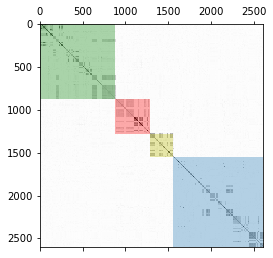

In [5]:
#Example how output should looks like after the following command
plot_pairwise(prodom["similarity"], prodom["labels"])

<img src="attachment:prodom_data_visualization.png" width="250">



<p style="background-color:#adebad;">
    2. Demonstrate your implementation of <b> plot_pairwise() </b> below.
</p>

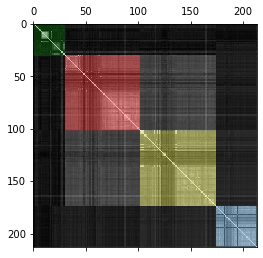

In [6]:
plot_pairwise(protein["dissimilarity"], protein["labels"])

<p style="background-color:#adebad;"> 
<b>NOTE</b>: Please follow these guidelines: <br>
</p>
<ul style="background-color:#adebad;"> 
<li> Use consistent notation throughout the notebook. </li>
<li> Define every variable properly. </li>
<li> Define every math notation before usage. </li>
<li> Use math mode with $$ for formulas. </li>
</ul>

<p style="background-color:#adebad;">
Read reference [1] and answer the following questions:
</p>
<p style="background-color:#adebad;">
3. Provide a description of general comcept of EM algorithm (not presented in the paper) with main formulas. <br>
</p>

The EM algorithm is a general iterative scheme used to find the maximum likelihood or the maximum a posteriori estimates of model parameters. The algorithm iteratively alternates between perfomming an expectaition step, where the expectation of the log-likelihood is evaluated using fixed estimates of model parameters, and a maximization step, where the model parameters are computed which maximize the log-likelihood found in the expectation step.

General algorithm for maximum likelihood estimation of model parameters $\theta$
- Expectation Step: $$Q(\theta|\theta^{(t)})=E_{Z|X,\theta^{(t)}}[ \log L(\theta;X,Z) ], $$ where $Q(\theta|\theta^{(t)})$ is the expected value of the log likelihood function of $\theta$, $Z$ is the current conditional distribution given $X$, the feature set, and current estimates of $\theta^{(t)}$, and $L(\theta;X,Z)=p(X,Z|\theta)$ is the corresponding likelihood. 

- Maximization Step: $$\theta^{(t+1)}=\arg \max_\theta +Q(\theta|\theta^{(t)}).$$ The model parameters are found which maximize the expeted log likelihood found in the exepctation step.
     

<p style="background-color:#adebad;">
4. Why it is not possible to apply EM-scheme for central clustering (algorithm I in [1]) to the case of pairwise clustering? <br>
</p>

The EM-scheme for central clustering can not be used for pairwise clustering. This is because while in the case of central clustering, the Gibbs distribution used to calculate the expectation values of the assignment of data to clusters is rewritten in a factorial form, in pairwise lustering, the Gibbs distribution cannot be exactly rewritten in factorial form. This is due to the fact that the data assignments in pairwise clustering are statistically dependent. 

<p style="background-color:#adebad;">
5. Provide a description of idea mean-field approximation (as KL divergency minimization problem) with main formulas. How does mean field approximaiton approach help to solve problem from the previous question?<br>
</p>

In mean-field approximation, the Gibbs distribution of the pairwise clustering cost funciton $P(\mathcal{H}^{pc})$ with interactions is approximated with $\mathcal{E}$-parameterized family of distributions $P^0({\mathcal{E}})$, and neglects the correlations between stochastic variables in the pairwise clustering cost function $\mathcal{H}^{pc}$. The goal is to determine the optimal approximation $\mathcal{E}^*$ such that the corresponding distribution $P^0({\mathcal{E}^*})$ represents the statistics of the original problam most accurately. $\mathcal{E}^*$ can be calculated as follows: $$\mathcal{E}^* = \arg \min_\mathcal{E} \mathcal{I} \left(P^0\left(\mathcal{E}\right) || P\left(\mathcal{H}^{pc}\right)\right),$$ where $\mathcal I(\cdot || \cdot)$ is the Kullback-Leibler divergence. This can then be used to calculate the optimal assignments: $$\langle M_{i\alpha} \rangle = \frac{\exp ( -\mathcal{E}^*_{i\alpha}/T)}{\sum^K_{\nu =1} \exp( -\mathcal{E}^*_{i\nu}/T)}.$$ Furthermore, a further approximation of $\mathcal{E}^*$ can be made $$ \mathcal{E}^*_{i\nu}=\frac{1}{\langle p_\nu \rangle N}\sum_{k=1}^N \langle M_{k\nu}\rangle \left(D_{ik} - \frac{1}{2\langle p_\nu \rangle N} \sum^N_{j=1} \langle M_{j\nu} \rangle D_{jk} \right) $$ with the purpose of simplifying it, where terms of low order are neglected, and zero self-dissimilarities are assumed.

In the previous question we stated that the Gibbs distribution cannot be exactly rewritten in a factorial form due to the fact that the data assignments are statistically dependent, i.e. each assignment variable $M_{i\nu}$ interacts with all other assignment varialbes. In the limit of large data sets, however, the cost contributions of these interactions average in the limit of large data sets and reduce the influnce of correlations on individual data assignments. 

The mean field approximatin approach helps us solve the problem from the previous question, because we can use it to approximate the average interaction of individual data assignments, with other assignment variables. 

<p style="background-color:#adebad;">
6. Provide a description of EM algorithm for pairwise clustering for the case if we have proximity data (algorithm II in [1]). <br>
</p>

Innitialize: 
- $\mathcal{E}^{*(0)}_{i\nu}$ and $\langle M_{i\nu} \rangle ^{(0)}\in (0,1)$ randomly
- temperature $T \leftarrow T_0$

While $T> T_{\mathrm{FINAL}}$:
> $t \leftarrow 0$

> Repeat untill convergence:
> > E-like step: estimate $\langle M_{i\nu} \rangle ^{(t+1)}$ as a function of $\mathcal{E}^{*(t)}_{i\nu}$ $$\langle M_{i\alpha} \rangle ^{(t+1)}= \frac{\exp ( -\mathcal{E}^{*(t)}_{i\alpha}/T)}{\sum^K_{\nu =1} \exp( -\mathcal{E}^{*(t)}_{i\nu}/T)};$$
> > M-like step: calculate $\mathcal{E}^{*(t+1)}_{i\nu}$ for given $\langle M_{i\nu} \rangle ^{(t+1)}$ $$ \mathcal{E}^{*(t+1)}_{i\nu}=\frac{1}{\langle p_\nu \rangle N}\sum_{k=1}^N \langle M_{k\nu}\rangle^{(t+1)} \left(D_{ik} - \frac{1}{2\langle p_\nu \rangle N} \sum^N_{j=1} \langle M_{j\nu}^{(t+1)} \rangle D_{jk} \right); $$
> > $t\leftarrow t+1;$

> $T\leftarrow T/2;$ $\langle M_{i\nu} \rangle ^{(0)}$ $\leftarrow \langle M_{i\nu} \rangle ^{(t)}$; $\mathcal{E}^{*(0)}_{i\nu}\leftarrow \mathcal{E}^{*(t)}_{i\nu}$

<p style="background-color:#adebad;">   
7. Implement the <b>fit_predict()</b> method without embedding (Algorithm II in [1]) for the template <b>class PairwiseClustering</b>, according to its docstring. You can add more class methods if necessary <br>
</p>

In [7]:
from time import time
from tqdm.notebook import trange
from tqdm.notebook import tqdm

class PairwiseClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for PairwiseClustering (PC)
    
    Attributes:
        M (np.ndarray): Assignment probability matrix (n_samples, n_clusters)
        centroids (np.ndarray): Embedding centroids (n_clusters, n_components), used only if embed is True.
        embeddings (np.ndarray): Embeddings of input samples (n_samples, n_components),
                                 used only if embed is True.
    Parameters:
        n_clusters (int): Maximum number of clusters.
        random_state (int): Random seed.
        embed (bool): Indicator, if data should be clustered and embedded simultaneously (algorithm III),
                      or not (algorithm II).
        n_components (int): Dimension of embedding space, used only if embed is True
    """
    
    def __init__(self, n_clusters=4, random_state=1, embed=False, n_components=2, T=1, T_f=0.0001, eps=1e-4, rate=0.5, eps_embed=0.05):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.embed = embed
        self.n_components = n_components
        self.T = T
        self.T_f = T_f
        self.eps = eps
        self.rate = rate
        self.M = None
        self.E = None
        self.eps_embed = eps_embed
        # Add more parameters, if necessary.
        
        self.X=None
        self.N = None
        
        self.F = None
        self.Y = None
    
    def fit_predict(self, X):
        """Compute PC for dissimilarity matrix X
        
        Compute cluster assignments. If embed is True, also compute embeddings/centroids.
         
        Args:
            X (np.ndarray): Dissimilarity matrix (n_samples, n_samples)
        
        Returns:
            C (np.ndarray): Assignments (n_samples,). 
            This is MAP estimation obtained from matrix M in accordance with notation from reference [1]. 
        """
        np.random.seed(self.random_state)
        self.X = X
        self.N = X.shape[0]
        
        self.M = np.random.rand(X.shape[0], self.n_clusters)
        self.E = np.random.rand(X.shape[0], self.n_clusters)
        if self.embed == False:
            isnan=False
            #Algorithm II from [1] should be implemented here (this is part of the Section 4.0)
            
            #initialize
            
            while self.T > self.T_f:
                store_E=(np.ones(self.E.shape)*1e+100)
                inner_M=(np.ones(self.M.shape)*1e+100)
                outer_M = self.M.copy()
                
                iter_till_break = 0
                while np.linalg.norm(inner_M-self.M)>1e-4 and np.linalg.norm(store_E-self.E)>1e-3 and iter_till_break < 30:
                    store_E = self.E.copy()
                    inner_M = self.M.copy()
                    M = self.Expectation()
                    if not np.isnan(np.sum(M)):
                        self.M = M
                    else: isnan = True; break
                    E = self.Maximization()
                    if not np.isnan(np.sum(E)):
                        self.E = E
                    else: isnan = True; break
                    iter_till_break+=1
                
                if np.linalg.norm(outer_M - self.M) < 1e-6 or isnan:
                    break
                self.T=self.T*self.rate  
            return np.argmax(self.M,axis=1)

        if self.embed == True:
            #Algorithm III from [1] should be implemented here (this is part of the Section 6.0)
            

            self.F = np.random.rand(self.X.shape[0], self.n_components)
            self.Y = np.random.rand(self.n_clusters, self.n_components)

            isnan=False
            while self.T > self.T_f:
                store_E=(np.ones(self.E.shape)*1e+100)
                inner_M=(np.ones(self.M.shape)*1e+100)
                outer_M = self.M.copy()
                
                iter_till_break = 0
                for ex in range(4):
                    store_E = self.E.copy()
                    inner_M = self.M.copy()
                    M = self.Expectation()
                    if not np.isnan(np.sum(M)): self.M = M
                    else: isnan = True;break
                    E = self.M_like()
                    if not np.isnan(np.sum(E)): self.E = E
                    else: isnan = True;break
                    y_copy = np.ones(self.Y.shape)*1e+10
                    f_copy = np.ones(self.F.shape)*1e+10
                    for early in range(4):
                        y_copy = self.Y.copy()
                        f_copy = self.F.copy()
                        
                        F = self.calc_x()
                        if not np.isnan(np.sum(F)) : 
                            self.F = F
                        else: break
                        Y = self.update_y()
                        if not np.isnan(np.sum(Y)) : 
                            self.Y = Y
                        else: break
                        num1 = np.linalg.norm(y_copy-self.Y)
                        num2 = np.linalg.norm(f_copy-self.F)
                    iter_till_break+=1
                    
                if np.linalg.norm(outer_M - self.M) < 1e-6 or isnan:
                    break
                self.T=self.T*self.rate  
            return np.argmax(self.M,axis=1)


    def M_like(self):
        E = np.zeros(self.E.shape)
        for eta in range(self.n_clusters):
            E[:,eta] = ( (1/(2*self.N*self.p_nu(eta)))*self.X@(self.M[:, eta][:,np.newaxis,]) )[:,0]
        return E
        
    def calc_x(self):
        SumEta = np.zeros(self.Y[0,:].shape)
        F = np.zeros(self.F.shape)

        for i in range(self.N):
            for eta in range(self.n_clusters):
                SumMu = np.zeros(self.Y[0,:].shape)
                for mu in range(self.n_clusters):
                    SumMu += self.M[i,mu] * self.Y[mu,:]
                SumEta += (np.linalg.norm(self.Y[eta, :])**2 - self.E[i,eta])*(self.Y[eta, :]-SumMu)
            Kx = 0.5 * SumEta
            yy = np.zeros((self.Y.shape[1], self.Y.shape[1]))
            y = np.zeros(self.Y.shape[1])
            for eta in range(self.n_clusters):
                yy += self.M[i,eta]*(self.Y[eta,:][:, np.newaxis]@self.Y[eta,:][np.newaxis,:])
                y += self.M[i,eta]*self.Y[eta,:]
            K = yy - y[:,np.newaxis]@y[np.newaxis,:]
            try:np.linalg.inv(K)
            except np.linalg.LinAlgError as err:
                if "Singular matrix" in str(err):
                    K=K+np.eye(K.shape[0])*1e-2;
                else:
                    raise
            try:np.linalg.inv(K)
            except np.linalg.LinAlgError as err:
                if "Singular matrix" in str(err):
                    K=K+np.eye(K.shape[0])*1e-2;
                    return self.F
                else:
                    raise
                    

            F[i,:]=(np.linalg.inv(K)@Kx[:,np.newaxis])[:,0]

        return F 
        
    def update_y(self):
        Y = np.zeros(self.Y.shape)
        for eta in range(self.n_clusters):
            SumUp = np.zeros(self.F.shape[1])
            SumDown = 0
            for k in range(self.N):
                SumUp+= self.M[k,eta] *self.F[k,:]
                SumDown+= self.M[k,eta]
            Y[eta,:] = SumUp/SumDown
        return Y

    def p_nu(self,nu):
        return np.sum(self.M[:,nu]/self.N)
        
    def Expectation(self):
        M = np.zeros(self.M.shape)
        expET = np.exp(-self.E/(self.T))
        sumexpET = np.sum(expET, axis=1)[:,np.newaxis]
        M = expET / (sumexpET)
        M = M / np.sum(M, axis=1)[:,np.newaxis]
        return M
            
    def Maximization(self):
        E = np.zeros(self.E.shape)
        for nu in range(self.n_clusters):
            SumIn = self.M[:,nu][:,np.newaxis]*self.X

            SumOut = self.M[:,nu][np.newaxis,:] * (self.X - (1/(2*self.N*self.p_nu(nu)))* 
                                                   np.sum(SumIn,axis=0)[np.newaxis,:])
            E[:,nu]= (1/(self.p_nu(nu)*self.N))* np.sum(SumOut,axis=1) 
        return E
            
    def test_Maximization(self):
        E = self.E.copy()
        M = self.M.copy()
        for i in trange(self.N):
            for nu in range(self.n_clusters):
                SumOut = 0
                for k in range(self.N):
                    SumIn = 0
                    for j in range(self.N):
                        SumIn+=M[j,nu]*self.X[j,k]
                    SumOut += M[k,nu]*(self.X[i,k]-(self.n_clusters/(2*self.N))*SumIn)
                E[i, nu] = (self.n_clusters/self.N)*SumOut
        return E
    

            
    def cost(self, D, M):
        """Compute the costs of the clustering solution M for dissimilarity D.
        
        The costs refer to the pairwise clustering costs in eq. (16) of reference [1].
        
        Args:
            D (np.ndarray): Dissimilarity matrix (n_samples, n_samples)
            M (np.ndarray): Assignment probability matrix (n_samples, n_clusters)
            
        Returns:
            cost (float): Costs of current clustering
        """
        p_nus = np.zeros((self.n_clusters))
        for i in range(self.n_clusters):
            p_nus[i] = self.p_nu(i)
        
        SumNu = np.zeros(D.shape)
        for nu in range(self.n_clusters):
            SumNu += D * ( (1/self.p_nu(nu)) * M[:,nu][:,np.newaxis] @ M[:,nu][np.newaxis,:] -(1/self.n_clusters)  )
        cost = (1/(2*self.N)) * np.sum(SumNu)
                
        return cost
    def cost_test(self,D,M):
        cost = 0
        for k in trange(self.N):
            for l in range(self.N):
                SumIn=0
                for nu in range(self.n_clusters):
                    SumIn+=(M[k,nu]*M[l,nu]/self.p_nu(nu))
                SumIn -= 1
                cost += (D[k,l]*SumIn)/self.N
        cost = cost/2
        return cost
     


Tricks to improve convergence without affecting the final cluster structure:

- Low T leads to nan values: There is a safety net set up; matrices M and E are not directly modified during maximization and instead copies of these matrices are updated. These are then saved if the matrices do not contain nan values. If the matrix contains a nan value then the algorithm is terminated.
- Early stopping: During EM-like process convergence is judged based on the norm of $\left(M^{t+1}-M^{t}\right)$, and $\left(E^{t+1}- E^{t}\right)$. $T$ is stepped down if these values are low enough. In some examples, however, the convergence near this number is very slow, although it is already close to this number. A maximum iteration number was set to prevent the algorithm from taking too long. 

<p style="background-color:#adebad;">
8. Create an instance of your Pairwise Clustering (PC) class, then fit and predict the Protein data. <br>
9. Record the execution time.
</p>

In [8]:
%%time
PC = PairwiseClustering()
labels_PC = PC.fit_predict(protein["dissimilarity"])

Wall time: 217 ms


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this (4.5.1-4.5.5) and previous sections to get a grade of 4.5 </span>
</h2>

In this section, you have to compare pairwise clustering with another clustering approach, that also works with proximity data, in terms of different metrics.

<p style="background-color:#adebad;">
1. Read https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering and shortly recap the idea of spectral clustering.
</p>

Spectral clustering is a scheme for clustering proximity data, taking a corresponding similarity matrix as an input. Similarly to our application in CE-4, spectral clustering first creates an embedding into the euclidean space and then clusters the embedding with traiditional -- euclidean vector based -- algorithms, such as k-Means. 

<p style="background-color:#adebad;">
2. Predict the Protein data with sklearn.SpectralClustering. <br>
3. Record the execution time. <br>
</p>

In [9]:
%%time
SC = skl.cluster.SpectralClustering(n_clusters=4, random_state=42, affinity="precomputed")
affinities = np.exp(- protein["dissimilarity"] / 3) # SC takes positive affinities as input
labels_spectral= SC.fit_predict(affinities)

Wall time: 106 ms


<p style="background-color:#adebad;">
4. Complete the function <b>compare_clusterings()</b> and use it to compare the spectral and the pairwise clustering methods. <br>
Use the following metrics to compare clustering:
</p>
<ul style="background-color:#adebad;"> 
<li> V-measure cluster labeling given a ground truth. </li>
<li> Normalized Mutual Information between two clusterings. </li>
<li> Homogeneity metric of a cluster labeling given a ground truth. </li>
<li> The Fowlkes-Mallows score </li>
<li> Rand index adjusted for chance. </li>
<li> Adjusted Mutual Information between two clusterings. </li>
</ul>
<p style="background-color:#adebad;">
Hint: use <b>sklearn.metrics.v_measure_score(),sklearn.metrics.normalized_mutual_info_score(), sklearn.metrics.homogeneity_score(), sklearn.metrics.fowlkes_mallows_score(), sklearn.metrics.completeness_score(), sklearn.metrics.adjusted_rand_score(), sklearn.metrics.adjusted_mutual_info_score()</b>. You can also find explanations and examples there: scikit-learn.org
</p>

In [10]:
def compare_clusterings(labels_true, **labels_pred):
    """Show a summary of different clustering metrics
    
    Args:
        labels_true (array): Ground-truth cluster labels
    
    Note:
        Each kwarg should be an array with predicted labels
    """
    
    
    n_pred = len(labels_pred)

    
    scores = []
    for name in dir(skl.metrics.cluster):
        score = getattr(skl.metrics.cluster, name)
        try:
            score(labels_true=[0], labels_pred=[0]) # Check if score takes the right arguments
            if "score" not in score.__name__:
                raise TypeError
            if score.__name__ == "mutual_info_score":
                raise TypeError
            if score.__name__ == "rand_score":
                raise TypeError
        except TypeError:
            continue
        else:
            scores.append(score)
    score_dict = {}
    for key, val in labels_pred.items():
        score_dict[key] = {}
        for score in scores:
            score_dict[key][score.__name__] = score(labels_true, val)
        
    return score_dict
    

<p style="background-color:#adebad;">
    5. Demonstrate your implementation of <b>compare_clusterings()</b>. See example of how the output should look like below. You should produce one plot. Hint: use <b>matplotlib.pyplot.barh(), matplotlib.pyplot.xticks(), matplotlib.pyplot.yticks()</b> to get horizontal histogram for different metrics as shown below.

</p>

,SpectralClustering,PairwiseClustering,Ground Truth
v_measure_score,0.803341,0.946050,1
normalized_mutual_info_score,0.803341,0.946050,1
homogeneity_score,0.750683,0.948206,1
fowlkes_mallows_score,0.842005,0.975888,1
completeness_score,0.863943,0.943904,1
adjusted_rand_score,0.763129,0.966625,1
adjusted_mutual_info_score,0.799650,0.945148,1


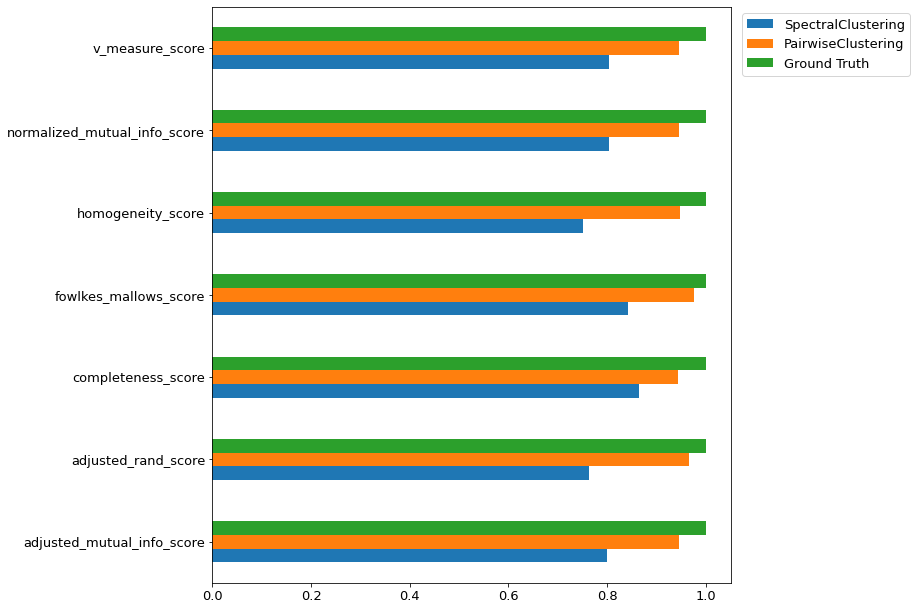

In [11]:
#Example how output sould looks like after the following command
score_dict = compare_clusterings(labels_true=protein["labels"],
                        SpectralClustering=labels_spectral,
                        PairwiseClustering=labels_PC)
def show_results(score_dict):
    scores = {}
    index = []
    indexing = True
    for key in score_dict:
        scores[key] = []
        for score in score_dict[key]:
            if indexing: index.append(score)
            scores[key].append(score_dict[key][score])
        indexing = False
    scores['Ground Truth'] = []
    for i in range(len(score_dict[key])):
        scores['Ground Truth'].append(1)
    df = pd.DataFrame(scores, index = index)
    df.plot.barh(fontsize=13)
    plt.legend(loc='upper left' ,bbox_to_anchor=(1.01, 1), fontsize=13)
    plt.subplots_adjust(left=0.0, right=1.2, bottom=0.0, top=2)
    return df.iloc[::-1]
show_results(score_dict)

<img src="attachment:data_visualiztion.png" width="700">

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this (5.0.1-5.0.5) and previous sections to get a grade of 5.0 </span>
</h2>

In this section, you have to investigate the quality of clustering depending on various transformations from similarity data to dissimilarity data and compare results, in terms of different metrics.

<p style="background-color:#adebad;">
    As PairwiseClustering takes dissimilarities as input, we need to transform the similarity data from <b>Prodom</b> accordingly.<br>
    1. Run <b>fit_predict()</b> with all the transformations and parameters below. Run compare_clusterings for each set of parameter values for your <b>PairwiseClustering</b> algorithm. <br>
    2. Produce output of <b>compare_clusterings()</b> for tranformation families below. You should get 3 plots: 1st transformation family comparison, 2nd transformation family comparison, then comparison between of the best transformations of every tranformation family.<br>
<b>NOTE</b>: By best transformation here and further in the notebook is meant the transformation that leads to a maximum average score of scores above for pairwise clustering.
</p>

In [12]:
S = prodom["similarity"]

In [13]:
#Transformationion family 1
D_list_1 = [((np.max(S) - S) / (np.max(S) - np.min(S))) ** 1, ((np.max(S) - S) / (np.max(S) - np.min(S))) ** 2, np.exp(((np.max(S) - S) / (np.max(S) - np.min(S))))]

PC_labels_1 = []
for D in tqdm(D_list_1):
    PC = PairwiseClustering()
    PC_labels_1.append(PC.fit_predict(D))

  0%|          | 0/3 [00:00<?, ?it/s]

,transf1,transf2,transf3,Ground Truth
v_measure_score,0.182115,0.192642,0.193450,1
normalized_mutual_info_score,0.182115,0.192642,0.193450,1
homogeneity_score,0.179514,0.189430,0.190648,1
fowlkes_mallows_score,0.361975,0.395861,0.391725,1
completeness_score,0.184792,0.195965,0.196336,1
adjusted_rand_score,0.066946,0.113002,0.109505,1
adjusted_mutual_info_score,0.180968,0.191508,0.192320,1


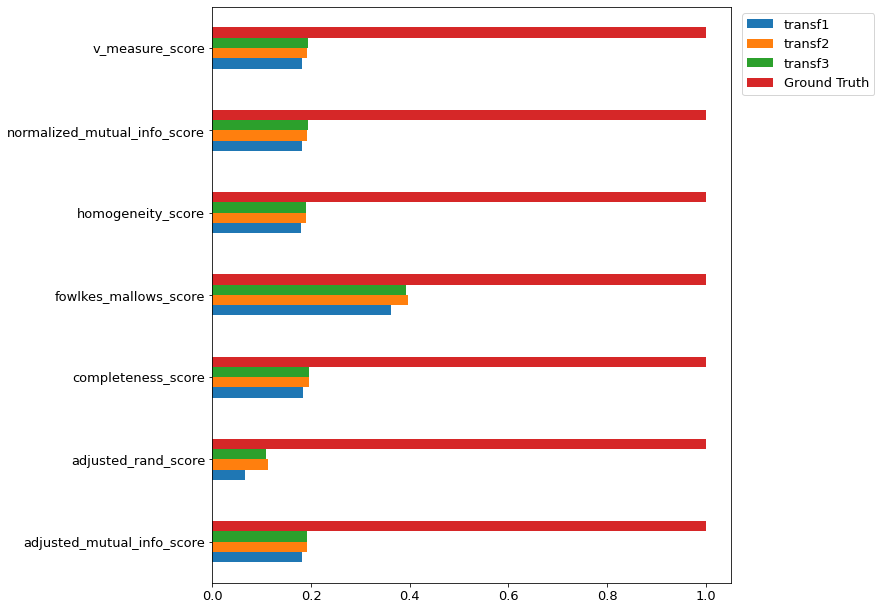

In [14]:
score_dict = compare_clusterings(labels_true=prodom["labels"],
                        transf1=PC_labels_1[0],
                        transf2=PC_labels_1[1],
                        transf3=PC_labels_1[2])
df_family1 = show_results(score_dict)
df_family1

In [15]:
D_list_2 =[(np.max(S) / (1 + S - np.min(S))) ** 1, (np.max(S) / (1 + S - np.min(S))) ** 0.5, np.log((np.max(S) / (1 + S - np.min(S))))]

PC_labels_2 = []
for D in D_list_2:
    
    PC = PairwiseClustering()
    PC_labels_2.append(PC.fit_predict(D))

,transf1,transf2,transf3,Ground Truth
v_measure_score,0.413152,0.450931,0.362284,1
normalized_mutual_info_score,0.413152,0.450931,0.362284,1
homogeneity_score,0.415267,0.448733,0.348111,1
fowlkes_mallows_score,0.546241,0.560913,0.440525,1
completeness_score,0.411058,0.453150,0.377660,1
adjusted_rand_score,0.343920,0.359988,0.148129,1
adjusted_mutual_info_score,0.412346,0.450169,0.361368,1


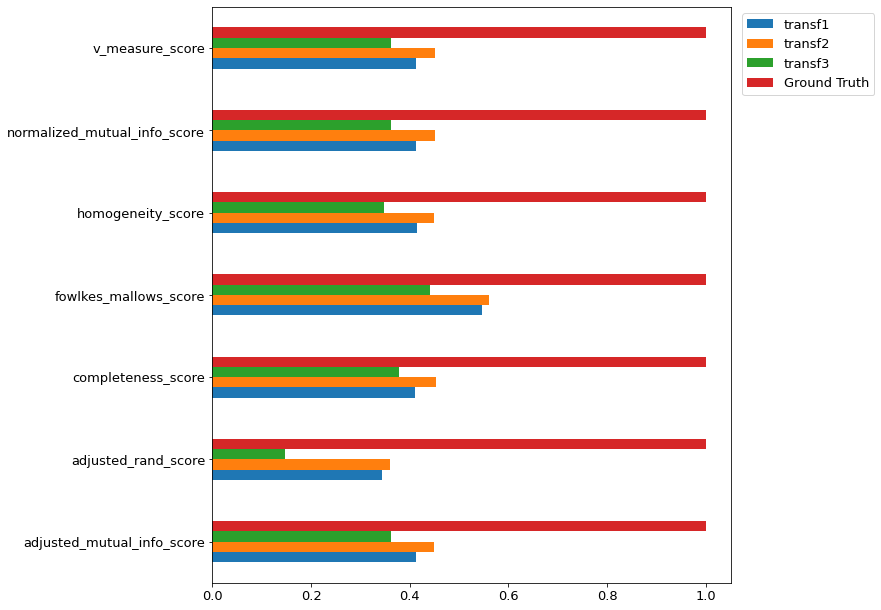

In [16]:
score_dict = compare_clusterings(labels_true=prodom["labels"],
                        transf1=PC_labels_2[0],
                        transf2=PC_labels_2[1],
                        transf3=PC_labels_2[2])
df_family2 = show_results(score_dict)
df_family2

In [17]:
np_family1 = df_family1.to_numpy()[:, :-1]
np_family2 = df_family2.to_numpy()[:, :-1]
np_family1_mean = np.mean(np_family1, axis=0)
np_family2_mean = np.mean(np_family2, axis=0)
family1_opt_idx = np.argmax(np_family1_mean)
family2_opt_idx = np.argmax(np_family2_mean)
print('Optimal Transform Idx Family 1:', family1_opt_idx, ' with average score:', np.max(np_family1_mean))
print('Optimal Transform Idx Family 2:', family2_opt_idx, ' with average score:', np.max(np_family2_mean))

Optimal Transform Idx Family 1: 1  with average score: 0.2101498843343679
Optimal Transform Idx Family 2: 1  with average score: 0.45354528368774377


,family1_opt,family2_opt,Ground Truth
v_measure_score,0.192642,0.450931,1
normalized_mutual_info_score,0.192642,0.450931,1
homogeneity_score,0.189430,0.448733,1
fowlkes_mallows_score,0.395861,0.560913,1
completeness_score,0.195965,0.453150,1
adjusted_rand_score,0.113002,0.359988,1
adjusted_mutual_info_score,0.191508,0.450169,1


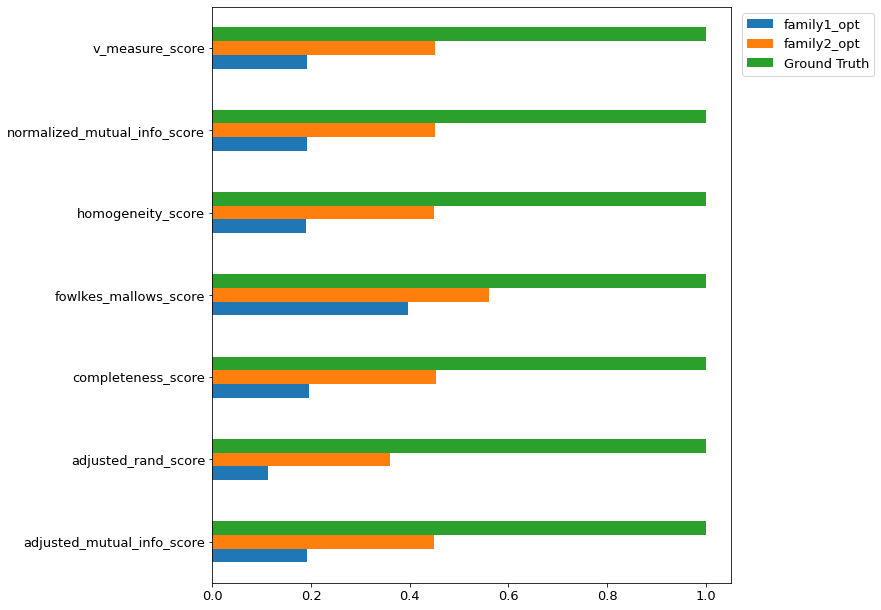

In [18]:
score_dict = compare_clusterings(labels_true=prodom["labels"],
                        family1_opt=PC_labels_1[family1_opt_idx],
                        family2_opt=PC_labels_2[family2_opt_idx])
df_family_opts = show_results(score_dict)
df_family_opts

In [19]:
np_family_opts = df_family_opts.to_numpy()[:, :-1]
np_family_opts = np.mean(np_family_opts, axis=0)
family_opts_idx = np.argmax(np_family_opts)
if family_opts_idx == 0:
    opt_labels = PC_labels_1[family1_opt_idx]
    print('Optimal transform is index:', family1_opt_idx, 'from family 1')
if family_opts_idx == 1:
    opt_labels = PC_labels_2[family2_opt_idx]
    print('Optimal transform is index:', family2_opt_idx, 'from family 2')

Optimal transform is index: 1 from family 2


<p style="background-color:#adebad;">
3. Provide description of another reasonable transformation from similarity to dissimilarity and explain your choice. <br>
<b>NOTE</b>: By reasonable transformation, it is meant some transformation that allows mapping given dissimilarity values to similarity ones in a meaningful way: higher similarity value should correspond to smaller dissimilarity values.
</p>

Inspired by the paper Optimal Cluster Preserving Embedding of Nonmetric Proximity Data, the following transformation from similarity to dissimilarity was implemented:
$$D_{ij} = S_{ii} + S_{jj}-2S_{ij}$$
This is a simple transformation provides higher dissimilarities between two nodes $i$ and $j$ with lower similarity values. Furthermore, the elements of the transformation $ S_{ii}+S_{jj} $ prevent the dissimilarity values from becoming negative. Furthermore, to avoid numerical issues, we scale down D by a factor of the median value of D in order to avoid using huge numbers. 


<p style="background-color:#adebad;">
4. Implement your transformation. <br>
5. Compare your transformation using <b>compare_clusterings()</b> with the best from task 4.0.2. You should get one plot. <br>
</p>

In [20]:
D = np.zeros(S.shape)
for i in trange(S.shape[0]):
    for j in range(S.shape[1]):
        D[i,j]=S[i,i]+S[j,j]-2*S[i,j]
D = D/np.mean(D)

  0%|          | 0/2604 [00:00<?, ?it/s]

In [21]:
PC = PairwiseClustering()
pred_labels =PC.fit_predict(D)

,D_of_choicce,families_opt,Ground Truth
v_measure_score,0.166720,0.450931,1
normalized_mutual_info_score,0.166720,0.450931,1
homogeneity_score,0.160930,0.448733,1
fowlkes_mallows_score,0.349158,0.560913,1
completeness_score,0.172941,0.453150,1
adjusted_rand_score,0.021490,0.359988,1
adjusted_mutual_info_score,0.165527,0.450169,1


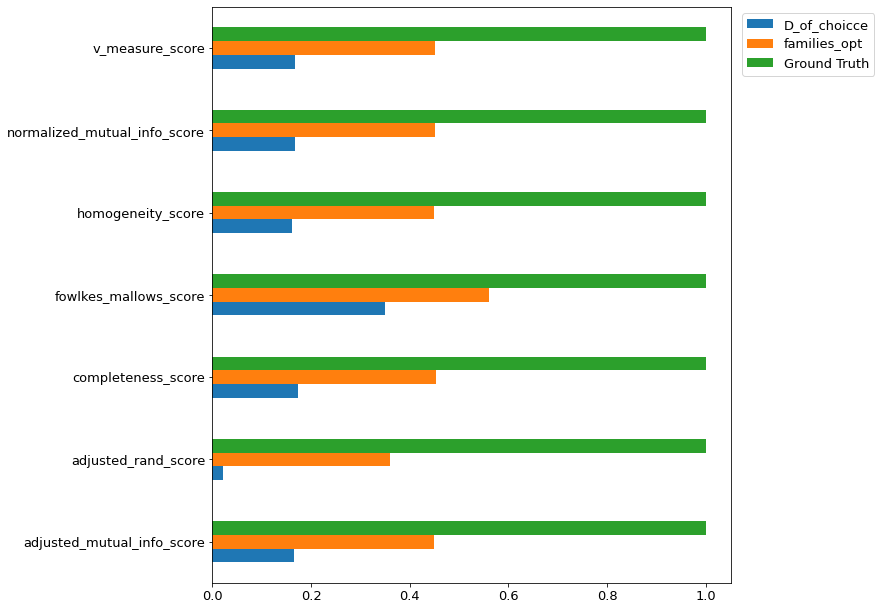

In [22]:
score_dict = compare_clusterings(labels_true=prodom["labels"], D_of_choicce=pred_labels, families_opt=opt_labels)
df_choice_v_family_opt = show_results(score_dict)
df_choice_v_family_opt

In [23]:
np_choice_v_family_opt = df_choice_v_family_opt.to_numpy()[:, :-1]
np_choice_v_family_opt = np.mean(np_choice_v_family_opt, axis=0)
print('Average accuracy using custom D:', np_choice_v_family_opt[0])
print('Average accuracy using optimal D found from family of transformations:', np_choice_v_family_opt[1])
choice_v_family_opt = np.argmax(np_choice_v_family_opt)
if choice_v_family_opt == 0:
    print('Dissimilarity of choice is most optimal')
else:
    print('Optimal dissimilarity from family of transformations is most optimal')

Average accuracy using custom D: 0.17192656290175948
Average accuracy using optimal D found from family of transformations: 0.45354528368774377
Optimal dissimilarity from family of transformations is most optimal


<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this (5.5.1-5.5.6) and previous sections to get a grade of 5.5 </span>
</h2>

In this section, you have to implement and calculate cost function and investigate the stability of pairwise clustering in terms of obtained values of clustering cost function, providing experiments for different random seeds and numer of clusters.

<p style="background-color:#adebad;">
1. Implement the cost function of the <b>PairwiseClustering class</b>. <br>
2. Compute cost function for <b>Protein</b> data. <br>
3. Calculate execution time. <br>
</p>

In [24]:
%%time
PC = PairwiseClustering()
labels_PC = PC.fit_predict(protein["dissimilarity"])
print('Cost:',PC.cost(PC.X, PC.M))

Cost: -307.83212705971
Wall time: 234 ms


<p style="background-color:#adebad;">
4. Re-run <b>fit_predict()</b> with 10 different random seeds and plot the distribution of clustering costs as shown in Figure 1 of reference [1]. <br>
5. Visualize the histograms of obtained cost functions.You should get 2 histograms; one for <b>Prodom</b> and the other for <b>Protein</b> data. Hint: use <b>matplotlib.plot.hist()</b> to plot histograms of cost functions.
</p>

<p style="background-color:#adebad;">
<b>NOTE:</b> For ProDom data use best option from section 5.0 to transform similiarities to dissimiliraties. 
</p>

In [25]:
D_prodom = D_list_2[1] #best option

In [26]:
# Please use Problem 5.0 to transform similarities for ProDom data
# data = [protein,prodom]
# other parameters are default

# Please add your code here
cost_protein=[]
cost_prodom=[]
for random_seed in trange(10):
    PC_protein = PairwiseClustering(random_state=random_seed)
    labels_PC_protein = PC_protein.fit_predict(protein["dissimilarity"])
    cost_protein.append(PC_protein.cost(PC_protein.X, PC_protein.M))

    PC_prodom = PairwiseClustering(random_state=random_seed)
    labels_PC_prodom = PC_prodom.fit_predict(D_prodom)
    cost_prodom.append(PC_prodom.cost(PC_prodom.X, PC_prodom.M))

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Histogram for prodom')

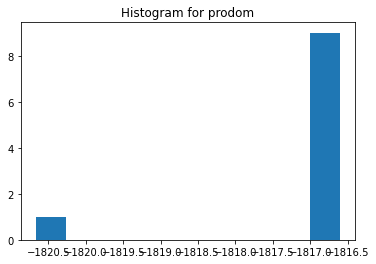

In [27]:
plt.hist([round(num, 11) for num in cost_prodom])
plt.title('Histogram for prodom')

Text(0.5, 1.0, 'Histogram for protein')

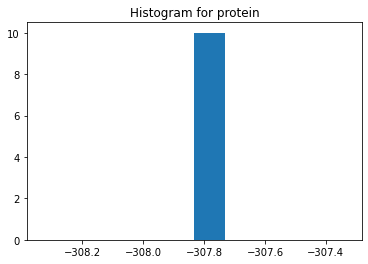

In [28]:
plt.hist([round(num, 15) for num in cost_protein])
plt.title('Histogram for protein')

<p style="background-color:#adebad;">
6. Perform the experiment for all the settings listed below, and visualize the results properly. You should get 4 histograms; one for each different number of clusters. <br>
</p>

In [29]:
n_clusters = [2, 4, 6, 8]
data = protein
# other parameters are default

#Please add your code here
all_costs = []
shapes=[]
for n_clusters_i in n_clusters:
    costs=[]
    
    for random_seed in trange(10):
        PC_protein = PairwiseClustering(n_clusters=n_clusters_i, random_state=random_seed)
        labels_PC_protein = PC_protein.fit_predict(data["dissimilarity"])
        costs.append(PC_protein.cost(PC_protein.X, PC_protein.M))
        
        shapes.append(PC_protein.M.shape)
    all_costs.append(costs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Histogram using 2 clusters')

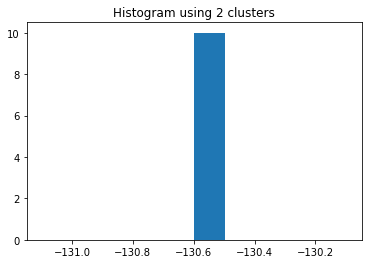

In [30]:
plt.hist(all_costs[0])
plt.title('Histogram using 2 clusters')

Text(0.5, 1.0, 'Histogram using 4 clusters')

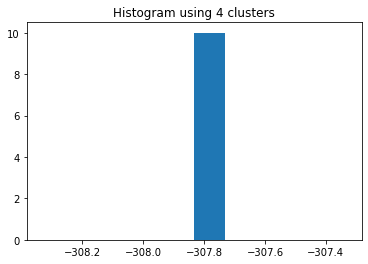

In [31]:
plt.hist([round(num, 15) for num in all_costs[1]])
plt.title('Histogram using 4 clusters')

Text(0.5, 1.0, 'Histogram using 6 clusters')

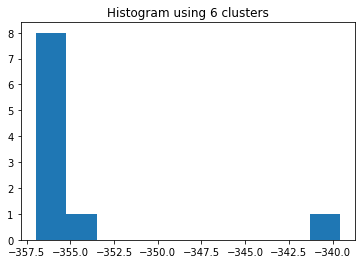

In [32]:
plt.hist(all_costs[2])
plt.title('Histogram using 6 clusters')

Text(0.5, 1.0, 'Histogram using 8 clusters')

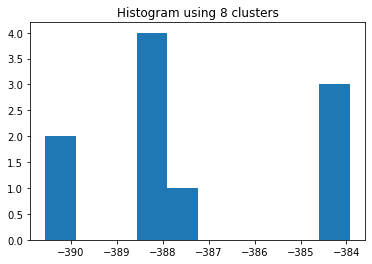

In [33]:
plt.hist(all_costs[3])
plt.title('Histogram using 8 clusters')

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems (6.0.1-6.0.5) in this and previous sections to get a grade of 6.0 </span>
</h2>



In this section, you have to implement an EM-like procedure to obtain data embeddings in Euclidean space, while visualizing these clusters on a 2d plane.

<p style="background-color:#adebad;">
1. Provide a description of the EM-like procedure for pairwise clustering in case we want to get emeddings (algorithm III in reference [1]). <br>
</p>

Algirthm 3 is a pairwise clustering algorithm, where the dissimilarity data is embedded  such that the statistics of the resulting cluster structure matches the statistics of the original pairwise clustering solution. In many ways the algorithm is similar to algorithm 2. Matrices M and E are calculated similarly, through an EM-like process, except E is calculated in a manner in which the elements of E can be approximated through $E_{i\nu}=||x_i-y_{\nu}||^2$. This approximation can also be calculated through  $E_{i\nu}= \frac{1}{2Np_\nu}\sum^N_{k=1}M_{k\nu}D_{ik}$ where elements of the dissimilarity matrix can be correctly approximated through $D_{ik}=||x_i -x_k||^2$. These relationships allow us to calculated E through matrices M and D. This M and D dependant function was used in the algorithm. In addition to this calculation, in the M-like step, the embeddings x and y are iteratively updated untill convergance using the calculated matrices E and M, the centroid condition and an appropriate approximation (33). 

<p style="background-color:#adebad;">
2.  Implement Algorithm III in [1], which explains how to compute an embedding within the EM-like procedure. In code <b>fit_predict()</b>: the <b>embed == True</b> part.<br>
3. Predict clustering for <b>Protein</b> data.<br>
4. Calculate execution time.<br>
</p>

Tricks to improve convergence without affecting the final cluster structure:

- Low T leads to nan values: There is a safety net set up; matrices M and E are not directly modified during maximization and instead copies of these matrices are updated. These are then saved if the matrices do not contain nan values. If the matrix contains a nan value then the algorithm is terminated.
- Early stopping: During EM-like process it was observed that the magnitudes of the embeddings explode leading to the algorithm becoming usntable. Furhermore, it was observed that using only a few iterations per EM-like step, the final cluster structure was not affected. This is judged based on the fact that the accuracies of the resulitng clustering is similar to that of the clusters generated by algorithm 2. See the plots below.
- K matrix becoming singular: In certain cases K became singular and so certain embeddings could not be calculated, since we need to take its inverse. To overcome this issue, I added a small value to the diagonal elements to avoid this incase the K proved to be singular. 

In [34]:
%%time
np.random.seed(111)
PCE = PairwiseClustering(embed=True, n_components=2)
labels = PCE.fit_predict(protein['dissimilarity'])
#Please add your code here

Wall time: 6.45 s


,PCE,PairwiseClustering,Ground Truth
v_measure_score,0.885313,0.946050,1
normalized_mutual_info_score,0.885313,0.946050,1
homogeneity_score,0.874997,0.948206,1
fowlkes_mallows_score,0.938875,0.975888,1
completeness_score,0.895875,0.943904,1
adjusted_rand_score,0.914174,0.966625,1
adjusted_mutual_info_score,0.883357,0.945148,1


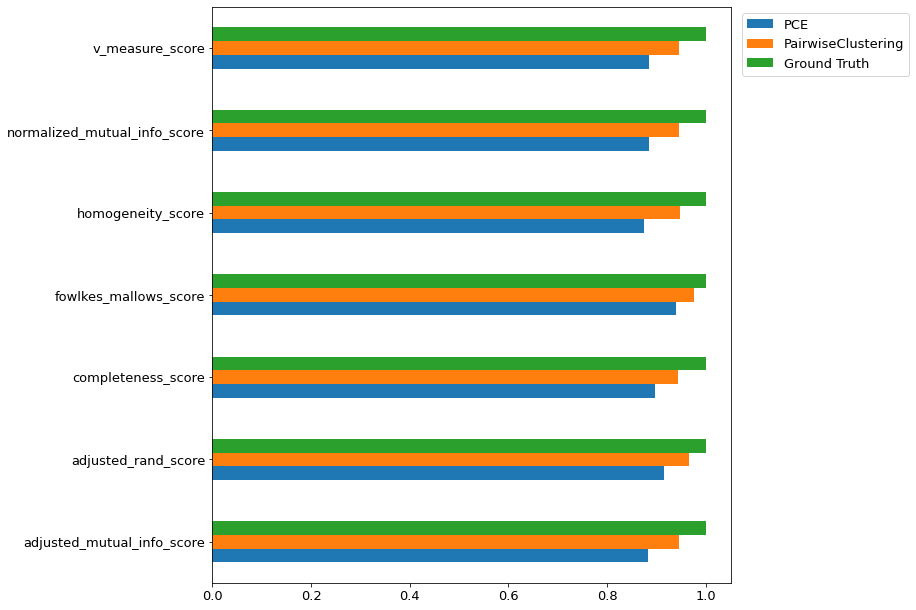

In [35]:
score_dict = compare_clusterings(labels_true=protein["labels"], PCE=labels, PairwiseClustering=labels_PC)
df_PCE = show_results(score_dict)
df_PCE

<p style="background-color:#adebad;">
5. Cluster the Protein data and properly visualize the embedding for <b>n_components=2</b>. Hint: <b>use matplotlib.pyplot.scatter()</b> to plot clusters on 2d plane using different colors for different clusters.
</p>

Text(0.5, 1.0, 'Labelled embeddings')

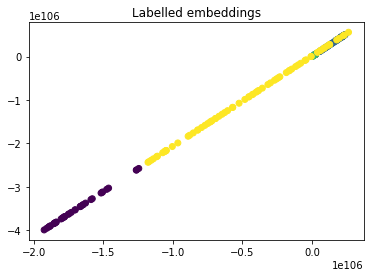

In [36]:
plt.scatter(PCE.F[:,0], PCE.F[:,1], c=labels)
plt.title('Labelled embeddings')

Text(0.5, 1.0, 'Labelled embeddings transformed using PCA')

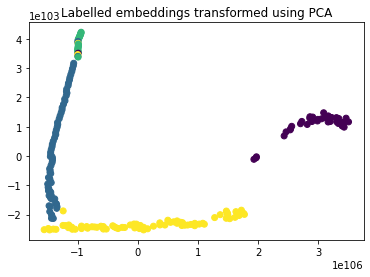

In [37]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(PCE.F)
F_transformed = pca.transform(PCE.F)
plt.scatter(F_transformed[:,0], F_transformed[:,1], c=labels)
plt.title('Labelled embeddings transformed using PCA')

PCA was used simply to set the axis as the principle components of the embedded data. This helps to study the structure of the embedded data.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.